In [1]:
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from cnn_finetune import make_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.metrics import auc

from efficientnet_pytorch import EfficientNet

from torchvision import transforms
from torchvision.transforms import InterpolationMode


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet

In [3]:
# 定数の定義
NUM_CLASSES_CURET = 61  # CUReTデータセットのクラス数を指定します
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
NUM_EPOCHS = 150

In [4]:
# データセットの変換を定義
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained('efficientnet-b0')

model._fc = nn.Linear(model._fc.in_features, NUM_CLASSES_CURET)

# モデルをデバイスに移動
model = model.to(device)

print(model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [6]:
# CUReTデータセットでの学習
train_dataset_CUReT = torchvision.datasets.ImageFolder(root='/home/yamaguchi/CUReT dataset_png/train')  
valid_dataset_CUReT  = torchvision.datasets.ImageFolder(root='/home/yamaguchi/CUReT dataset_png/valid')   

transform = torchvision.transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BILINEAR),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_CUReT.transform=transform
valid_dataset_CUReT.transform=transform

train_loader_CUReT = DataLoader(train_dataset_CUReT, BATCH_SIZE, shuffle=False)
valid_loader_CUReT = DataLoader(valid_dataset_CUReT, BATCH_SIZE, shuffle=False)


optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [7]:
def train(device, model, optimizer, criterion, train_loader_CUReT, valid_loader_CUReT, NUM_EPOCHS=300, model_save_path='best_model.pth'):
    model.to(device)
    
    best_valid_acc = 0.0  # 最良の検証精度を追跡するための変数

    for epoch in range(NUM_EPOCHS):
        model.train()  # モデルをトレーニングモードに設定
        
        # Training loop
        running_loss_train = 0.0
        correct_num_train = 0
        total_num_train = 0
        batch_count_train = 0
        
        for data,target in train_loader_CUReT:
            # データをGPUに移動 (もし利用可能な場合)
            inputs, labels = data.to(device), target.to(device)
            
            # 勾配をゼロに設定
            optimizer.zero_grad()
            
            # 順伝播
            outputs = model(inputs)
            
            # 損失の計算
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_train_temp = (predicted==labels).sum()
            correct_num_train += correct_num_train_temp.item()
            total_num_train += data.shape[0]
            
            # 逆伝播
            loss.backward()
            
            # 重みの更新
            optimizer.step()
            
            # 統計を記録
            running_loss_train += loss.item()
            batch_count_train += 1
        
        print('epoch:%d train loss: %.3f train acc: %.3f' %
             (epoch + 1, running_loss_train / batch_count_train, correct_num_train*100/total_num_train))
        
        # Validation loop
        model.eval()  # モデルを評価モードに設定
#         total_valid_loss = 0
#         total_valid_correct = 0
#         total_valid_samples = 0
        running_loss_valid = 0.0
        correct_num_valid = 0
        total_num_valid = 0
        batch_count_valid = 0
        avg_valid_loss =0
        valid_accuracy=0
        
        
        with torch.no_grad():
            for data,target in valid_loader_CUReT:
                inputs, labels = data.to(device), target.to(device)
                
                # 順伝播
                outputs = model(inputs)
                
                # 損失の計算
                loss = criterion(outputs, labels)
                
                # 統計を記録
#                 _, preds = torch.max(outputs, 1)
#                 total_valid_loss += loss.item()
#                 total_valid_correct += (preds == labels).sum().item()
#                 total_valid_samples += labels.size(0)
                loss = criterion(outputs, labels)
                predicted = torch.max(outputs.data, 1)[1]
                correct_num_valid_temp = (predicted==labels).sum()
                correct_num_valid += correct_num_valid_temp.item()
                total_num_valid += data.shape[0]
                
                
                running_loss_valid += loss.item()
                batch_count_valid += 1
        
        avg_valid_loss = running_loss_valid / batch_count_valid
        valid_accuracy = correct_num_valid*100/total_num_valid
        
        print('epoch:%d valid loss: %.3f valid acc: %.3f' %
             (epoch + 1, avg_valid_loss, valid_accuracy))
        
        
        # 最良の検証精度を持つモデルを保存
        
        if valid_accuracy > best_valid_acc:
            best_valid_acc = valid_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"Improved validation accuracy to {best_valid_acc:.4f}%. Model saved at '{model_save_path}'")

In [8]:
train(device, model, optimizer, criterion, train_loader_CUReT, valid_loader_CUReT, NUM_EPOCHS=100, model_save_path='BEST_model_CUReT.pth')

epoch:1 train loss: 4.309 train acc: 0.232
epoch:1 valid loss: 4.091 valid acc: 2.981
Improved validation accuracy to 2.9808%. Model saved at 'BEST_model_CUReT.pth'
epoch:2 train loss: 4.200 train acc: 0.479
epoch:2 valid loss: 4.076 valid acc: 3.903
Improved validation accuracy to 3.9035%. Model saved at 'BEST_model_CUReT.pth'
epoch:3 train loss: 4.136 train acc: 1.066
epoch:3 valid loss: 4.082 valid acc: 4.258
Improved validation accuracy to 4.2583%. Model saved at 'BEST_model_CUReT.pth'
epoch:4 train loss: 4.093 train acc: 1.777
epoch:4 valid loss: 4.055 valid acc: 5.110
Improved validation accuracy to 5.1100%. Model saved at 'BEST_model_CUReT.pth'
epoch:5 train loss: 4.061 train acc: 2.650
epoch:5 valid loss: 4.057 valid acc: 5.962
Improved validation accuracy to 5.9617%. Model saved at 'BEST_model_CUReT.pth'
epoch:6 train loss: 4.029 train acc: 3.732
epoch:6 valid loss: 4.043 valid acc: 6.742
Improved validation accuracy to 6.7424%. Model saved at 'BEST_model_CUReT.pth'
epoch:7 tr

epoch:76 valid loss: 5.087 valid acc: 8.588
epoch:77 train loss: 0.052 train acc: 99.807
epoch:77 valid loss: 5.225 valid acc: 8.659
epoch:78 train loss: 0.047 train acc: 99.876
epoch:78 valid loss: 5.182 valid acc: 8.446
epoch:79 train loss: 0.045 train acc: 99.900
epoch:79 valid loss: 5.115 valid acc: 8.659
epoch:80 train loss: 0.042 train acc: 99.923
epoch:80 valid loss: 5.076 valid acc: 8.446
epoch:81 train loss: 0.044 train acc: 99.784
epoch:81 valid loss: 5.099 valid acc: 8.659
epoch:82 train loss: 0.040 train acc: 99.930
epoch:82 valid loss: 5.080 valid acc: 8.446
epoch:83 train loss: 0.042 train acc: 99.907
epoch:83 valid loss: 4.895 valid acc: 9.226
epoch:84 train loss: 0.037 train acc: 99.954
epoch:84 valid loss: 5.003 valid acc: 9.652
epoch:85 train loss: 0.037 train acc: 99.930
epoch:85 valid loss: 5.039 valid acc: 8.943
epoch:86 train loss: 0.034 train acc: 99.946
epoch:86 valid loss: 5.159 valid acc: 8.872
epoch:87 train loss: 0.033 train acc: 99.907
epoch:87 valid loss: 

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# EfficientNetをインスタンス化
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=NUM_CLASSES_CURET)
# 保存したモデルのパラメータをロード
model.load_state_dict(torch.load('BEST_model_CUReT.pth', map_location=device)) 

# 新しいタスク用に出力層を変更
model._fc = nn.Linear(model._fc.in_features, 4)


# モデルを適切なデバイスに移動
model = model.to(device)

print(model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [10]:
#データセットの設定
train_dataset = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/train')  #学習用データ：データ数は560
test_dataset  = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/test') 

transform = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # ランダムに画像の色調を変更
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_2 = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


batch_size = 32

train_dataset.transform=transform
test_dataset.transform=transform_2
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

print(train_dataset.classes)


['1 normal', '2 MALT', '3 GCB', '4 Non-GCB']


In [11]:
from torchsummary import summary

summary(model, (3, 224, 224))

#https://discuss.pytorch.org/t/what-is-1-in-output-shape-of-a-model-in-torch-summary/67790

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

       ZeroPad2d-260           [-1, 1152, 9, 9]               0
Conv2dStaticSamePadding-261           [-1, 1152, 7, 7]          10,368
     BatchNorm2d-262           [-1, 1152, 7, 7]           2,304
MemoryEfficientSwish-263           [-1, 1152, 7, 7]               0
        Identity-264           [-1, 1152, 1, 1]               0
Conv2dStaticSamePadding-265             [-1, 48, 1, 1]          55,344
MemoryEfficientSwish-266             [-1, 48, 1, 1]               0
        Identity-267             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-268           [-1, 1152, 1, 1]          56,448
        Identity-269           [-1, 1152, 7, 7]               0
Conv2dStaticSamePadding-270            [-1, 320, 7, 7]         368,640
     BatchNorm2d-271            [-1, 320, 7, 7]             640
     MBConvBlock-272            [-1, 320, 7, 7]               0
        Identity-273            [-1, 320, 7, 7]               0
Conv2dStaticSamePadding-274           [-1, 1280, 7, 7]         409,6

In [12]:
# Train

def train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader):
    # Early stoppingの設定
    the_last_loss = 100  
    patience = 10
    trigger_times = 0

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        correct_num = 0
        total_num = 0
        batch_count = 0

        for data,target in  cv_train_dataloader:
            inputs, labels = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_temp = (predicted==labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1 

        print('epoch:%d loss: %.3f acc: %.3f' %
             (epoch + 1, running_loss / batch_count, correct_num*100/total_num))
            

        # Early stopping
        the_current_loss = validation(model, device, cv_valid_dataloader, criterion)
        print('The current loss:', the_current_loss)

        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        the_last_loss = the_current_loss

    return model

In [13]:
#validation

def validation(model, device, cv_valid_dataloader, criterion):
    model.eval()
    running_loss = 0

    with torch.no_grad():
        for data,target in cv_valid_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(cv_valid_dataloader)#

In [14]:

def test(device, model, test_dataloader):
    model.eval()
    
    correct_num = 0
    total_num = 0
    predicts_list = []
    labels_list = []
    scores_list=[] 

    with torch.no_grad():
        for data, target in test_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            m = nn.Softmax(dim=1)
            probs = m(outputs)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]

            device2 = torch.device('cpu')
            labels=labels.to(device2)
            predicted = predicted.to(device2)
            probs = probs.to(device2)

            labels_list.append(labels)
            predicts_list.append(predicted)
            scores_list.append(probs)  
    
        labels = torch.cat(labels_list)
        predicted = torch.cat(predicts_list)
        scores = torch.cat(scores_list)  

        labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])  # Changed to four classes

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(4):  # Changed loop range to four classes
            fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        C = confusion_matrix(labels, predicted)
        ac = accuracy_score(labels, predicted)
        pre = precision_score(labels, predicted, average='macro')
        re = recall_score(labels, predicted, average='macro')
        f1 = f1_score(labels, predicted, average='macro')

        AUC = roc_auc_score(labels, scores, multi_class='ovr')  

        print(C)
        print("\n")
        print("test accuracy : %.3f" % ac)
        print("test precison : %.3f" % pre)
        print("test recall : %.3f" % re)
        print("test f : %.3f" % f1)
        print("AUC : %.3f" %(AUC))

        for i in range(4):  # Changed loop range to four classes
            print("AUC for class {}: {:.3f}".format(i, roc_auc[i]))

        # Compute macro-average ROC curve and ROC area
        fpr_macro = dict()
        tpr_macro = dict()
        roc_auc_macro = dict()
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))  # Changed loop range to four classes
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(4):  # Changed loop range to four classes
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= 4  # Changed the denominator to four classes
        fpr_macro["macro"] = all_fpr
        tpr_macro["macro"] = mean_tpr
        roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr_macro["macro"], tpr_macro["macro"],
                 label='macro-average ROC curve (area = {:.3g})'.format(roc_auc_macro["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])  # Added one more color for the additional class
        class_labels = ['Normal lymph node', 'MALT lymphoma', 'GCB', 'Non-GCB']  # Changed to four class labels
        for i, color in zip(range(4), colors):  # Changed loop range to four classes
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:.3g})'
                     ''.format(class_labels[i], roc_auc[i]))

            
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        
        class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB']   # Changed to four class labels
        C = confusion_matrix(labels, predicted)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(C, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels,annot_kws={'size': 20})
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        plt.show()

            

In [15]:
#k分割交差検証

kf = KFold(n_splits=10)

Loaded pretrained weights for efficientnet-b0
Fold 1------------------------------------------------------------------------------
epoch:1 loss: 0.956 acc: 59.476
The current loss: 0.8454767669987889
trigger times: 0
epoch:2 loss: 0.781 acc: 66.897
The current loss: 0.7004356168452266
trigger times: 0
epoch:3 loss: 0.690 acc: 71.448
The current loss: 0.6013787537620878
trigger times: 0
epoch:4 loss: 0.617 acc: 74.799
The current loss: 0.5479284371730149
trigger times: 0
epoch:5 loss: 0.550 acc: 78.021
The current loss: 0.4786438543217636
trigger times: 0
epoch:6 loss: 0.486 acc: 80.726
The current loss: 0.4245979242716369
trigger times: 0
epoch:7 loss: 0.440 acc: 82.932
The current loss: 0.32977268460912734
trigger times: 0
epoch:8 loss: 0.385 acc: 85.147
The current loss: 0.3193016213289006
trigger times: 0
epoch:9 loss: 0.364 acc: 85.913
The current loss: 0.3818992338789583
trigger times: 1
epoch:10 loss: 0.326 acc: 87.086
The current loss: 0.3298489493530815
trigger times: 0
epoch:1

epoch:92 loss: 0.014 acc: 99.538
The current loss: 0.0005898352318042553
trigger times: 0
epoch:93 loss: 0.016 acc: 99.474
The current loss: 0.0005357457714905001
trigger times: 0
epoch:94 loss: 0.014 acc: 99.548
The current loss: 0.0010361532378686377
trigger times: 1
epoch:95 loss: 0.013 acc: 99.557
The current loss: 0.00048042213532273597
trigger times: 0
epoch:96 loss: 0.013 acc: 99.575
The current loss: 0.0015126579118530177
trigger times: 1
epoch:97 loss: 0.014 acc: 99.594
The current loss: 0.0009692518940375723
trigger times: 0
epoch:98 loss: 0.018 acc: 99.391
The current loss: 0.0006157580397923881
trigger times: 0
epoch:99 loss: 0.015 acc: 99.557
The current loss: 0.0015722283566355398
trigger times: 1
epoch:100 loss: 0.011 acc: 99.705
The current loss: 0.00038314726230395777
trigger times: 0
[[131  12   3   4]
 [  0 119   1   2]
 [  0   0  86 124]
 [  0   0 109 371]]


test accuracy : 0.735
test precison : 0.770
test recall : 0.758
test f : 0.763
AUC : 0.875
AUC for class 0: 

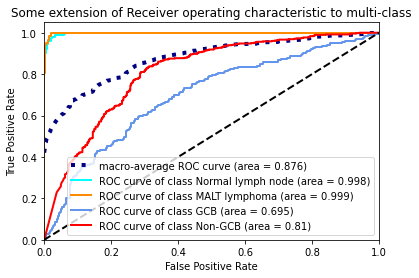

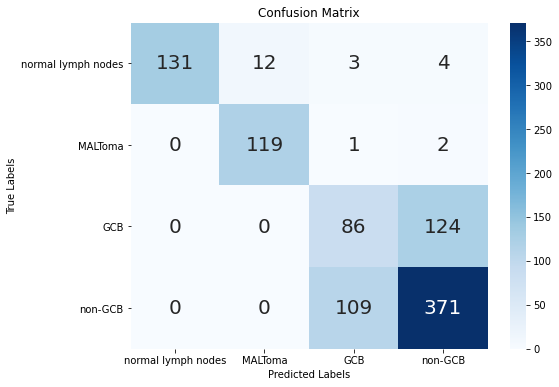

Loaded pretrained weights for efficientnet-b0
Fold 2------------------------------------------------------------------------------
epoch:1 loss: 0.964 acc: 59.282
The current loss: 0.9010716849679792
trigger times: 0
epoch:2 loss: 0.779 acc: 66.611
The current loss: 0.6949650158468293
trigger times: 0
epoch:3 loss: 0.687 acc: 70.941
The current loss: 0.6719096153878379
trigger times: 0
epoch:4 loss: 0.600 acc: 75.445
The current loss: 0.5652110209595137
trigger times: 0
epoch:5 loss: 0.535 acc: 78.473
The current loss: 0.46263843333310173
trigger times: 0
epoch:6 loss: 0.478 acc: 80.689
The current loss: 0.49610388236653313
trigger times: 1
epoch:7 loss: 0.432 acc: 82.876
The current loss: 0.6163784203265181
trigger times: 2
epoch:8 loss: 0.400 acc: 83.938
The current loss: 0.36297826685119905
trigger times: 0
epoch:9 loss: 0.351 acc: 86.172
The current loss: 0.7703099906208285
trigger times: 1
epoch:10 loss: 0.323 acc: 87.483
The current loss: 0.23264360224867958
trigger times: 0
epoc

epoch:92 loss: 0.017 acc: 99.446
The current loss: 0.0009944801445863998
trigger times: 0
epoch:93 loss: 0.018 acc: 99.455
The current loss: 0.002010143550305918
trigger times: 1
epoch:94 loss: 0.016 acc: 99.465
The current loss: 0.0014138004008525207
trigger times: 0
epoch:95 loss: 0.015 acc: 99.520
The current loss: 0.0008952898968044934
trigger times: 0
epoch:96 loss: 0.014 acc: 99.529
The current loss: 0.0007644081457730627
trigger times: 0
epoch:97 loss: 0.011 acc: 99.677
The current loss: 0.0008839910040176412
trigger times: 1
epoch:98 loss: 0.012 acc: 99.622
The current loss: 0.0004889283067316301
trigger times: 0
epoch:99 loss: 0.012 acc: 99.603
The current loss: 0.0007965664699378361
trigger times: 1
epoch:100 loss: 0.015 acc: 99.529
The current loss: 0.0005831428301730977
trigger times: 0
[[133   7   7   3]
 [  0 121   1   0]
 [  0   1  78 131]
 [  0   0  97 383]]


test accuracy : 0.743
test precison : 0.776
test recall : 0.762
test f : 0.767
AUC : 0.879
AUC for class 0: 0.9

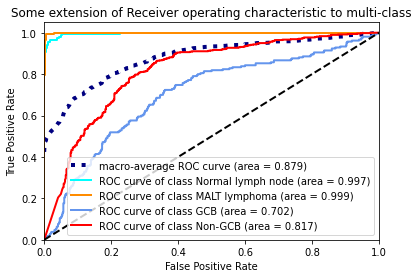

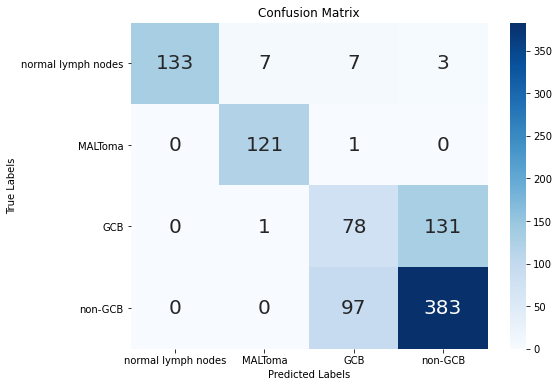

Loaded pretrained weights for efficientnet-b0
Fold 3------------------------------------------------------------------------------
epoch:1 loss: 0.963 acc: 58.950
The current loss: 0.9037548847782225
trigger times: 0
epoch:2 loss: 0.774 acc: 66.805
The current loss: 0.6997360040469419
trigger times: 0
epoch:3 loss: 0.681 acc: 71.661
The current loss: 0.5922188603492305
trigger times: 0
epoch:4 loss: 0.599 acc: 75.759
The current loss: 0.5252393395681165
trigger times: 0
epoch:5 loss: 0.538 acc: 77.938
The current loss: 0.46475797667577423
trigger times: 0
epoch:6 loss: 0.472 acc: 80.929
The current loss: 0.40876902175852947
trigger times: 0
epoch:7 loss: 0.425 acc: 82.959
The current loss: 0.48488564200831197
trigger times: 1
epoch:8 loss: 0.385 acc: 84.584
The current loss: 0.5494349872488061
trigger times: 2
epoch:9 loss: 0.338 acc: 86.504
The current loss: 0.26578353244947284
trigger times: 0
epoch:10 loss: 0.310 acc: 87.760
The current loss: 0.24886121218893567
trigger times: 0
epo

epoch:92 loss: 0.013 acc: 99.603
The current loss: 0.0012144967775547654
trigger times: 0
epoch:93 loss: 0.014 acc: 99.548
The current loss: 0.0007317557901291692
trigger times: 0
epoch:94 loss: 0.014 acc: 99.603
The current loss: 0.0008901920848228713
trigger times: 1
epoch:95 loss: 0.018 acc: 99.428
The current loss: 0.000799625785095609
trigger times: 0
epoch:96 loss: 0.014 acc: 99.529
The current loss: 0.0007685681700418444
trigger times: 0
epoch:97 loss: 0.014 acc: 99.502
The current loss: 0.0006136689295868238
trigger times: 0
epoch:98 loss: 0.013 acc: 99.557
The current loss: 0.0005225977212312488
trigger times: 0
epoch:99 loss: 0.015 acc: 99.446
The current loss: 0.0007592584958755287
trigger times: 1
epoch:100 loss: 0.014 acc: 99.603
The current loss: 0.0008089994436448165
trigger times: 2
[[140   3   4   3]
 [  0 122   0   0]
 [  0   0  74 136]
 [  0   0 116 364]]


test accuracy : 0.728
test precison : 0.770
test recall : 0.761
test f : 0.765
AUC : 0.869
AUC for class 0: 1.0

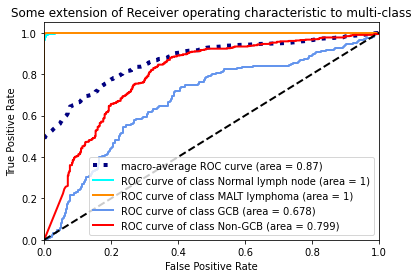

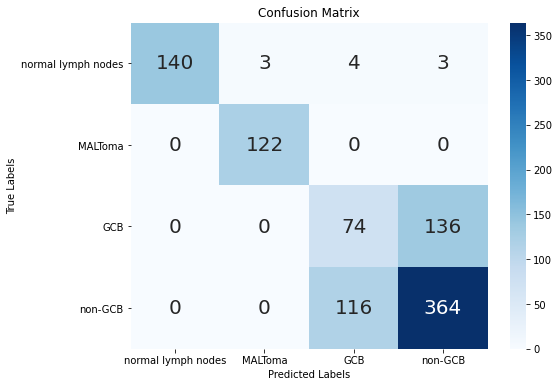

Loaded pretrained weights for efficientnet-b0
Fold 4------------------------------------------------------------------------------
epoch:1 loss: 0.952 acc: 59.725
The current loss: 0.8211314059233508
trigger times: 0
epoch:2 loss: 0.779 acc: 66.685
The current loss: 0.7089509343876775
trigger times: 0
epoch:3 loss: 0.696 acc: 70.368
The current loss: 0.6215594089741112
trigger times: 0
epoch:4 loss: 0.640 acc: 73.193
The current loss: 0.5453110475582139
trigger times: 0
epoch:5 loss: 0.572 acc: 76.507
The current loss: 0.5116216870076998
trigger times: 0
epoch:6 loss: 0.518 acc: 78.732
The current loss: 0.4400926373039089
trigger times: 0
epoch:7 loss: 0.471 acc: 80.578
The current loss: 0.39215747785759997
trigger times: 0
epoch:8 loss: 0.429 acc: 82.858
The current loss: 0.42188173158720665
trigger times: 1
epoch:9 loss: 0.386 acc: 84.206
The current loss: 0.45151048168817476
trigger times: 2
epoch:10 loss: 0.358 acc: 85.886
The current loss: 0.352109858442021
trigger times: 0
epoch:

epoch:92 loss: 0.018 acc: 99.382
The current loss: 0.0008981533587494183
trigger times: 1
epoch:93 loss: 0.016 acc: 99.437
The current loss: 0.0014232038094987996
trigger times: 2
epoch:94 loss: 0.014 acc: 99.548
The current loss: 0.00034167781772445887
trigger times: 0
epoch:95 loss: 0.016 acc: 99.483
The current loss: 0.000747019989823087
trigger times: 1
epoch:96 loss: 0.015 acc: 99.502
The current loss: 0.0009774120947879036
trigger times: 2
epoch:97 loss: 0.017 acc: 99.428
The current loss: 0.0005746143155272424
trigger times: 0
epoch:98 loss: 0.013 acc: 99.594
The current loss: 0.002789430676768507
trigger times: 1
epoch:99 loss: 0.018 acc: 99.428
The current loss: 0.0006567203667698456
trigger times: 0
epoch:100 loss: 0.015 acc: 99.520
The current loss: 0.0009727533424875163
trigger times: 1
[[136   3   4   7]
 [  0 112   2   8]
 [  1   0  72 137]
 [  0   0 104 376]]


test accuracy : 0.723
test precison : 0.769
test recall : 0.738
test f : 0.752
AUC : 0.871
AUC for class 0: 0.9

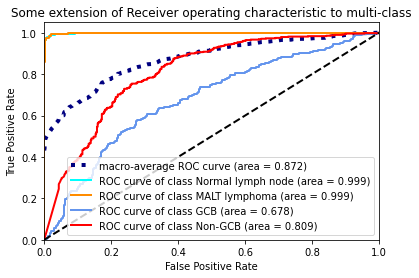

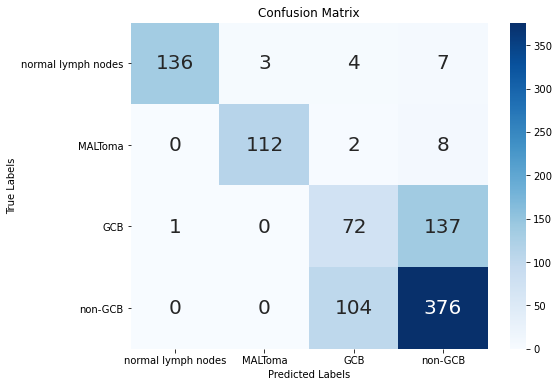

Loaded pretrained weights for efficientnet-b0
Fold 5------------------------------------------------------------------------------
epoch:1 loss: 0.952 acc: 60.131
The current loss: 0.8603882320818648
trigger times: 0
epoch:2 loss: 0.777 acc: 66.639
The current loss: 0.6887169171641182
trigger times: 0
epoch:3 loss: 0.675 acc: 72.325
The current loss: 0.6787430029911893
trigger times: 0
epoch:4 loss: 0.587 acc: 75.907
The current loss: 0.4962509388974964
trigger times: 0
epoch:5 loss: 0.523 acc: 79.092
The current loss: 0.4804985518306274
trigger times: 0
epoch:6 loss: 0.463 acc: 80.938
The current loss: 0.41901355695424486
trigger times: 0
epoch:7 loss: 0.419 acc: 83.052
The current loss: 0.34139754528668775
trigger times: 0
epoch:8 loss: 0.375 acc: 85.166
The current loss: 0.2936779218433963
trigger times: 0
epoch:9 loss: 0.338 acc: 87.040
The current loss: 0.2366402909605404
trigger times: 0
epoch:10 loss: 0.308 acc: 88.341
The current loss: 0.22587656302124834
trigger times: 0
epoch

epoch:92 loss: 0.016 acc: 99.520
The current loss: 0.0013577659750130787
trigger times: 1
epoch:93 loss: 0.015 acc: 99.529
The current loss: 0.0006721334957585353
trigger times: 0
epoch:94 loss: 0.016 acc: 99.465
The current loss: 0.0016715511657529214
trigger times: 1
epoch:95 loss: 0.014 acc: 99.548
The current loss: 0.0003242426337216743
trigger times: 0
epoch:96 loss: 0.011 acc: 99.705
The current loss: 0.000502336240011997
trigger times: 1
epoch:97 loss: 0.012 acc: 99.622
The current loss: 0.0014660235437727283
trigger times: 2
epoch:98 loss: 0.013 acc: 99.585
The current loss: 0.00041345296245600034
trigger times: 0
epoch:99 loss: 0.013 acc: 99.603
The current loss: 0.0006548949758931206
trigger times: 1
epoch:100 loss: 0.012 acc: 99.640
The current loss: 0.0005947817925327872
trigger times: 0
[[128  12   4   6]
 [  0 121   0   1]
 [  1   1  78 130]
 [  0   0 114 366]]


test accuracy : 0.720
test precison : 0.755
test recall : 0.745
test f : 0.748
AUC : 0.876
AUC for class 0: 0.

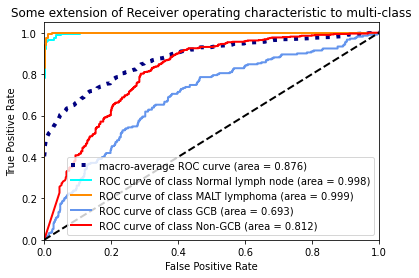

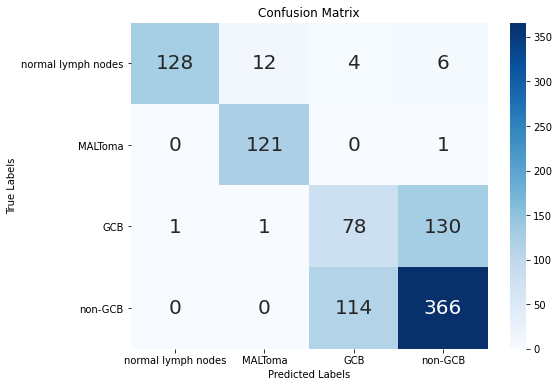

Loaded pretrained weights for efficientnet-b0
Fold 6------------------------------------------------------------------------------
epoch:1 loss: 0.949 acc: 60.085
The current loss: 0.879902150602819
trigger times: 0
epoch:2 loss: 0.768 acc: 67.442
The current loss: 0.8105763847991868
trigger times: 0
epoch:3 loss: 0.676 acc: 71.762
The current loss: 0.6503794635632308
trigger times: 0
epoch:4 loss: 0.603 acc: 74.873
The current loss: 0.5585422921392814
trigger times: 0
epoch:5 loss: 0.533 acc: 77.919
The current loss: 0.4740698472898904
trigger times: 0
epoch:6 loss: 0.481 acc: 80.467
The current loss: 0.38508914823844415
trigger times: 0
epoch:7 loss: 0.428 acc: 82.978
The current loss: 0.335937460839122
trigger times: 0
epoch:8 loss: 0.388 acc: 84.769
The current loss: 0.47955826140121505
trigger times: 1
epoch:9 loss: 0.350 acc: 86.218
The current loss: 0.3305008320740883
trigger times: 0
epoch:10 loss: 0.325 acc: 86.929
The current loss: 0.24082979351174977
trigger times: 0
epoch:1

epoch:92 loss: 0.016 acc: 99.529
The current loss: 0.0014492476926024438
trigger times: 1
epoch:93 loss: 0.016 acc: 99.437
The current loss: 0.0007029762555138178
trigger times: 0
epoch:94 loss: 0.014 acc: 99.585
The current loss: 0.0012595309307876727
trigger times: 1
epoch:95 loss: 0.016 acc: 99.492
The current loss: 0.0009866146311946623
trigger times: 0
epoch:96 loss: 0.017 acc: 99.465
The current loss: 0.0011598582313591956
trigger times: 1
epoch:97 loss: 0.016 acc: 99.446
The current loss: 0.0012813833187989942
trigger times: 2
epoch:98 loss: 0.016 acc: 99.520
The current loss: 0.00103378796353987
trigger times: 0
epoch:99 loss: 0.015 acc: 99.474
The current loss: 0.002116922616426531
trigger times: 1
epoch:100 loss: 0.017 acc: 99.483
The current loss: 0.0017526661694806983
trigger times: 0
[[135  10   2   3]
 [  0 113   3   6]
 [  1   0  66 143]
 [  0   0 107 373]]


test accuracy : 0.714
test precison : 0.748
test recall : 0.729
test f : 0.737
AUC : 0.870
AUC for class 0: 0.998

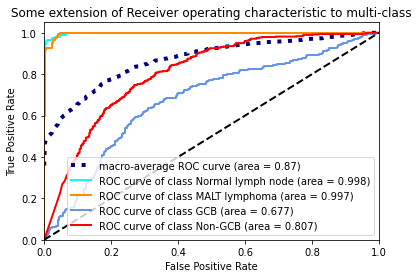

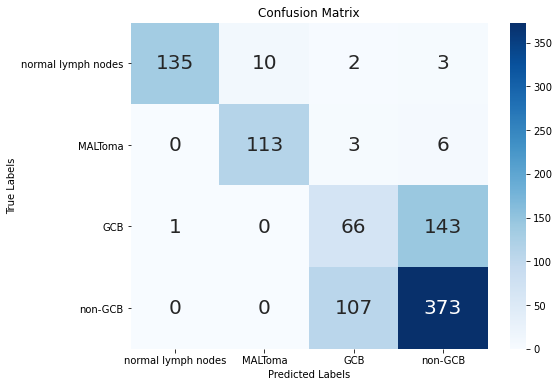

Loaded pretrained weights for efficientnet-b0
Fold 7------------------------------------------------------------------------------
epoch:1 loss: 0.961 acc: 59.706
The current loss: 0.895243056645963
trigger times: 0
epoch:2 loss: 0.773 acc: 67.322
The current loss: 0.6986314138963511
trigger times: 0
epoch:3 loss: 0.692 acc: 71.116
The current loss: 0.6091054172631474
trigger times: 0
epoch:4 loss: 0.602 acc: 75.085
The current loss: 0.5057896719888336
trigger times: 0
epoch:5 loss: 0.540 acc: 77.772
The current loss: 0.46435130595924623
trigger times: 0
epoch:6 loss: 0.475 acc: 80.846
The current loss: 0.47176374224389583
trigger times: 1
epoch:7 loss: 0.411 acc: 84.003
The current loss: 0.3182452531657827
trigger times: 0
epoch:8 loss: 0.373 acc: 84.981
The current loss: 0.33640781376966905
trigger times: 1
epoch:9 loss: 0.349 acc: 85.987
The current loss: 0.2700818818938921
trigger times: 0
epoch:10 loss: 0.309 acc: 88.064
The current loss: 0.2709893357478478
trigger times: 1
epoch:

epoch:92 loss: 0.013 acc: 99.649
The current loss: 0.0009399576007730831
trigger times: 1
epoch:93 loss: 0.014 acc: 99.585
The current loss: 0.0010157911897173831
trigger times: 2
epoch:94 loss: 0.015 acc: 99.520
The current loss: 0.0007389593086931437
trigger times: 0
epoch:95 loss: 0.018 acc: 99.409
The current loss: 0.0006922987380406911
trigger times: 0
epoch:96 loss: 0.012 acc: 99.649
The current loss: 0.0008421764669912526
trigger times: 1
epoch:97 loss: 0.012 acc: 99.649
The current loss: 0.00257284851675621
trigger times: 2
epoch:98 loss: 0.012 acc: 99.575
The current loss: 0.0013170700917541282
trigger times: 0
epoch:99 loss: 0.014 acc: 99.585
The current loss: 0.0005670344932676239
trigger times: 0
epoch:100 loss: 0.010 acc: 99.686
The current loss: 0.0006429221425945093
trigger times: 1
[[125  16   4   5]
 [  0 121   0   1]
 [  0   0  69 141]
 [  0   0 119 361]]


test accuracy : 0.703
test precison : 0.738
test recall : 0.726
test f : 0.729
AUC : 0.865
AUC for class 0: 0.99

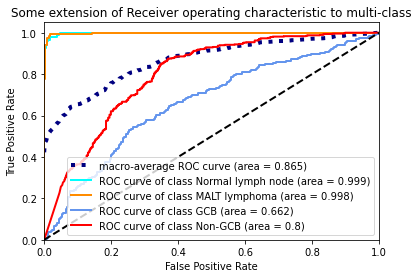

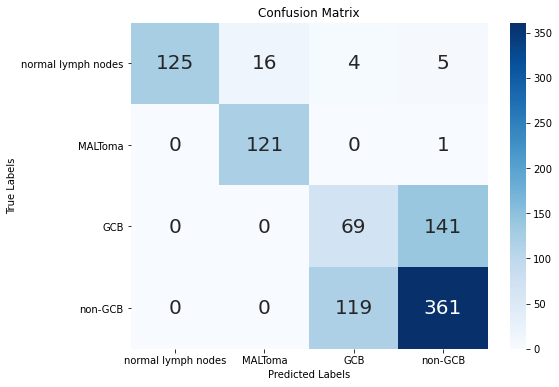

Loaded pretrained weights for efficientnet-b0
Fold 8------------------------------------------------------------------------------
epoch:1 loss: 0.959 acc: 58.756
The current loss: 0.8467004154987392
trigger times: 0
epoch:2 loss: 0.776 acc: 66.805
The current loss: 0.7169580586243608
trigger times: 0
epoch:3 loss: 0.691 acc: 70.941
The current loss: 0.6709264154878382
trigger times: 0
epoch:4 loss: 0.623 acc: 74.476
The current loss: 0.5510008699977688
trigger times: 0
epoch:5 loss: 0.550 acc: 78.049
The current loss: 0.5013228440739675
trigger times: 0
epoch:6 loss: 0.490 acc: 80.393
The current loss: 0.4352728105905661
trigger times: 0
epoch:7 loss: 0.434 acc: 82.978
The current loss: 0.5219076808959597
trigger times: 1
epoch:8 loss: 0.395 acc: 84.446
The current loss: 0.32073706375939115
trigger times: 0
epoch:9 loss: 0.355 acc: 86.144
The current loss: 0.33446238520225524
trigger times: 1
epoch:10 loss: 0.319 acc: 87.473
The current loss: 0.45834377966992895
trigger times: 2
epoch

epoch:92 loss: 0.013 acc: 99.566
The current loss: 0.001010043379664666
trigger times: 0
epoch:93 loss: 0.012 acc: 99.585
The current loss: 0.000993465812654646
trigger times: 0
epoch:94 loss: 0.014 acc: 99.557
The current loss: 0.0007489269536005248
trigger times: 0
epoch:95 loss: 0.014 acc: 99.529
The current loss: 0.0006689845043716062
trigger times: 0
epoch:96 loss: 0.015 acc: 99.418
The current loss: 0.0019296140143948946
trigger times: 1
epoch:97 loss: 0.015 acc: 99.474
The current loss: 0.0007804749319123413
trigger times: 0
epoch:98 loss: 0.014 acc: 99.566
The current loss: 0.0007390704825959556
trigger times: 0
epoch:99 loss: 0.012 acc: 99.557
The current loss: 0.0017208195545814744
trigger times: 1
epoch:100 loss: 0.011 acc: 99.649
The current loss: 0.0006654497679830645
trigger times: 0
[[143   0   4   3]
 [  0 118   1   3]
 [  0   0  63 147]
 [  0   0 112 368]]


test accuracy : 0.719
test precison : 0.764
test recall : 0.747
test f : 0.754
AUC : 0.871
AUC for class 0: 1.00

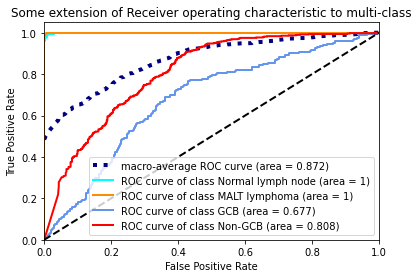

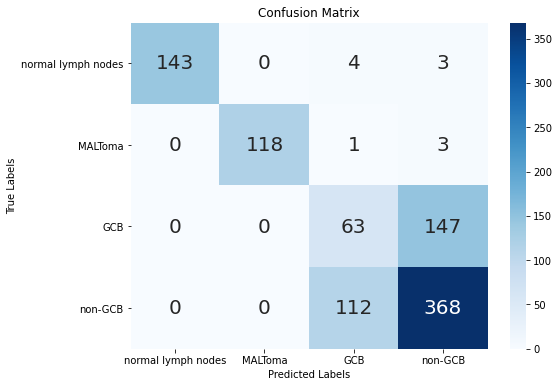

Loaded pretrained weights for efficientnet-b0
Fold 9------------------------------------------------------------------------------
epoch:1 loss: 0.954 acc: 60.020
The current loss: 0.855863611090236
trigger times: 0
epoch:2 loss: 0.770 acc: 66.934
The current loss: 0.7282988984676237
trigger times: 0
epoch:3 loss: 0.679 acc: 71.384
The current loss: 0.603193634758349
trigger times: 0
epoch:4 loss: 0.603 acc: 75.132
The current loss: 0.539172886558987
trigger times: 0
epoch:5 loss: 0.528 acc: 78.889
The current loss: 0.4643461599748219
trigger times: 0
epoch:6 loss: 0.454 acc: 82.073
The current loss: 0.45546468454316963
trigger times: 0
epoch:7 loss: 0.419 acc: 83.218
The current loss: 0.316447034881692
trigger times: 0
epoch:8 loss: 0.369 acc: 85.692
The current loss: 0.37766212321045894
trigger times: 1
epoch:9 loss: 0.325 acc: 87.067
The current loss: 0.32019061428219336
trigger times: 0
epoch:10 loss: 0.287 acc: 88.923
The current loss: 0.2217990351496759
trigger times: 0
epoch:11 

epoch:92 loss: 0.014 acc: 99.594
The current loss: 0.00042478453366459623
trigger times: 0
epoch:93 loss: 0.013 acc: 99.585
The current loss: 0.0005664133527330615
trigger times: 1
epoch:94 loss: 0.014 acc: 99.529
The current loss: 0.0006719725953578142
trigger times: 2
epoch:95 loss: 0.014 acc: 99.585
The current loss: 0.0010348240103076056
trigger times: 3
epoch:96 loss: 0.014 acc: 99.649
The current loss: 0.0004129838955620457
trigger times: 0
epoch:97 loss: 0.013 acc: 99.538
The current loss: 0.0005369492760307344
trigger times: 1
epoch:98 loss: 0.014 acc: 99.511
The current loss: 0.001534048736211326
trigger times: 2
epoch:99 loss: 0.014 acc: 99.548
The current loss: 0.0014249398200027795
trigger times: 0
epoch:100 loss: 0.014 acc: 99.520
The current loss: 0.000320301207725861
trigger times: 0
[[138   8   3   1]
 [  0 121   1   0]
 [  0   0  68 142]
 [  0   0 115 365]]


test accuracy : 0.719
test precison : 0.755
test recall : 0.749
test f : 0.751
AUC : 0.855
AUC for class 0: 0.9

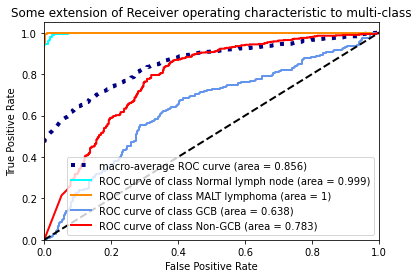

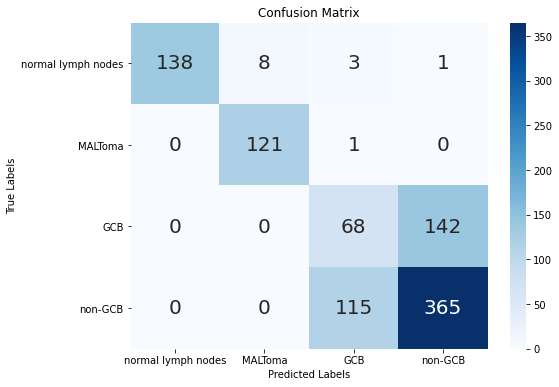

Loaded pretrained weights for efficientnet-b0
Fold 10------------------------------------------------------------------------------
epoch:1 loss: 0.959 acc: 59.633
The current loss: 0.854079820776144
trigger times: 0
epoch:2 loss: 0.776 acc: 66.925
The current loss: 0.6965873576645742
trigger times: 0
epoch:3 loss: 0.684 acc: 71.421
The current loss: 0.6156690682224094
trigger times: 0
epoch:4 loss: 0.612 acc: 74.448
The current loss: 0.531384582268651
trigger times: 0
epoch:5 loss: 0.527 acc: 78.612
The current loss: 0.4303658870721901
trigger times: 0
epoch:6 loss: 0.469 acc: 81.141
The current loss: 0.42205611602842785
trigger times: 0
epoch:7 loss: 0.430 acc: 82.950
The current loss: 0.36445439914152145
trigger times: 0
epoch:8 loss: 0.389 acc: 84.575
The current loss: 0.3065498239445915
trigger times: 0
epoch:9 loss: 0.338 acc: 86.707
The current loss: 0.25437387872101314
trigger times: 0
epoch:10 loss: 0.311 acc: 88.147
The current loss: 0.5154428360856669
trigger times: 1
epoch:

epoch:92 loss: 0.017 acc: 99.372
The current loss: 0.0011193975622453341
trigger times: 2
epoch:93 loss: 0.013 acc: 99.594
The current loss: 0.0007107087943936842
trigger times: 0
epoch:94 loss: 0.016 acc: 99.465
The current loss: 0.000809097412056211
trigger times: 1
epoch:95 loss: 0.011 acc: 99.677
The current loss: 0.0005025528637602722
trigger times: 0
epoch:96 loss: 0.014 acc: 99.548
The current loss: 0.0008510603648340288
trigger times: 1
epoch:97 loss: 0.015 acc: 99.566
The current loss: 0.0014582100572287963
trigger times: 2
epoch:98 loss: 0.015 acc: 99.455
The current loss: 0.0014140561674938078
trigger times: 0
epoch:99 loss: 0.012 acc: 99.622
The current loss: 0.0008663411592626113
trigger times: 0
epoch:100 loss: 0.011 acc: 99.705
The current loss: 0.0008286687417813643
trigger times: 0
[[135   3   8   4]
 [  0 120   0   2]
 [  0   0  80 130]
 [  0   0 127 353]]


test accuracy : 0.715
test precison : 0.767
test recall : 0.750
test f : 0.758
AUC : 0.871
AUC for class 0: 0.9

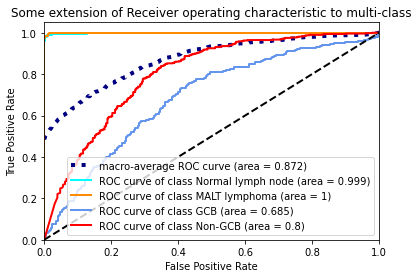

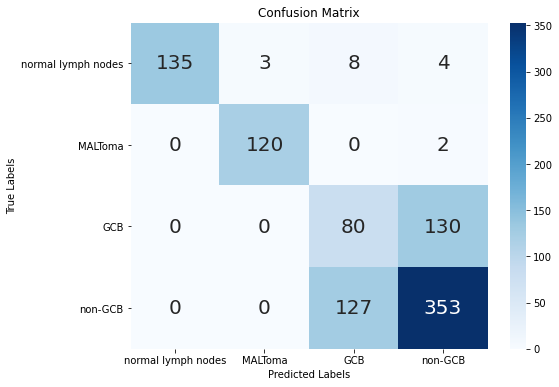

CPU times: user 8d 4h 39min 14s, sys: 21min 18s, total: 8d 5h 33s
Wall time: 1d 9h 47min 10s


In [16]:
%%time

def main():
    
    for _fold, (train_index, valid_index) in enumerate(kf.split(np.arange(len(train_dataset)))):
    
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # EfficientNetをインスタンス化
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=NUM_CLASSES_CURET)
        # 保存したモデルのパラメータをロード
        model.load_state_dict(torch.load('BEST_model_CUReT.pth', map_location=device)) 

        # 新しいタスク用に出力層を変更
        model._fc = nn.Linear(model._fc.in_features, 4)


        # モデルを適切なデバイスに移動
        model = model.to(device)

        batch_size = 32
        criterion = nn.CrossEntropyLoss()
        # Pass all model parameters to the optimizer
        optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) # Optimize the entire model for fine-tuning
        
        cv_train_dataset = Subset(train_dataset, train_index)
        cv_train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
        cv_valid_dataset   = Subset(train_dataset, valid_index)
        cv_valid_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
        
        print('Fold {}------------------------------------------------------------------------------'.format(_fold+1))

        model = train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader)
        test(device, model, test_dataloader)


if __name__ == '__main__':
    main()